In [1]:
from docplex.mp.model import Model  #导出库，只用这一个就够了
import matplotlib.pyplot as plt#选取了用户47的365天的数据
import numpy as np
import pandas as pd
import csv
import cplex
from cplex.exceptions import CplexError
import time
import math

In [2]:
 #read file, for example
file_path = 'C:/Users/chenxihui/Desktop/code/project/2010.csv'
file = open(file_path)
data = []
for i in file.readlines():
    data.append(i)
file.close()

new_data = []
for row in data:
    tmp = row.strip('\n')  #去掉每行最后的回车符
    tmp = tmp.split(',')   #根据','来分割字符串，使之成为含有一个个数据的列表
    new_data.append(tmp)   #new_data的每一行数据就是一个列表
select_data = []

length=len(new_data)
for i in range(length):
    if(new_data[i][0]=='82'):#PVsize为8kwp
        select_data.append(new_data[i][3:])#[3:]

GC=[]
CL=[]
GG=[]
Battery=[]
Length_select_data = len(select_data)
for i in range(Length_select_data):
    if(select_data[i][0]=='GC'):
        GC.append(select_data[i][2:])
    elif(select_data[i][0]=='CL'):
        CL.append(select_data[i][2:])
    else:
        GG.append(select_data[i][2:])
        
Total_Load=[]
temp=[]
a=0.0
for i in range(Length_select_data):
    if(select_data[i][0]=='GC' and select_data[i+1][0]=='CL'):
        for j in range(len(select_data[i][2:])):
            a=pd.to_numeric(select_data[i][j+2])+pd.to_numeric(select_data[i+1][j+2])
            temp.append(a)
        Total_Load.append(temp)
    elif(select_data[i][0]=='GC' and select_data[i+1][0]!='CL'):
        Total_Load.append(select_data[i][2:])
    temp=[]
    
GC_temp=np.array(GC)
GC_array=[]
GC_array = GC_temp.astype(np.float)

GG_temp=np.array(GG)
GG_array=[]
GG_array = GG_temp.astype(np.float)*2

Total_Load_temp=np.array(Total_Load)
Total_Load_array=[]
Total_Load_array = Total_Load_temp.astype(np.float32)*2#功率
Total_Load_array[1]


array([0.22 , 0.292, 0.498, 0.342, 0.412, 0.258, 0.36 , 0.342, 0.38 ,
       0.336, 4.098, 4.426, 5.248, 5.722, 5.162, 5.648, 6.234, 5.528,
       5.032, 4.974, 4.536, 0.718, 1.312, 1.122, 1.412, 2.216, 3.902,
       3.478, 2.592, 1.848, 2.202, 1.86 , 1.74 , 2.282, 4.138, 6.746,
       7.264, 9.5  , 8.316, 7.972, 3.558, 2.34 , 3.858, 6.76 , 6.792,
       3.314, 0.38 , 0.408], dtype=float32)

In [3]:
def SCM(load,GG):
    pb_bar,bat_max,bat_min,eff_i,eff_c,dh,pg_bar=5,14,0,0.9,0.95,0.5,np.max(load)
    pg_import,pg_export,pb_c,pb_d,pb_res,soc,e_b,eb_res,p_res=[],[],[],[],[],[],[0.5*bat_max],[],[]
    for d in np.arange(14,360,1):#天数设置
        for i in range(48):
            p_res.append(GG[d][i]*eff_i-load[d][i])
            #print(p_res[-1])
            #print(i)
            if(p_res[-1]>0.0):#发电量能满足需求的情况
                eb_res.append(bat_max-e_b[-1])
                #print(eb_res[-1])
                if(eb_res[-1]>0.0):#电池还能充电
                    #pb_c设置为pb_bar、p_res、将电池充满需要的电量中的最小值
                    pb_c.append(min(pb_bar,min(abs(p_res[-1])/(eff_i*eff_c),(eb_res[-1])/(dh*eff_c))))#此处改动原文eb_res[-1]/(dh*eff_c)
                    pg_export.append(abs(p_res[-1])-pb_c[-1]*eff_i*eff_c)#发电量满足充电后，卖电与eff_i有关
                    pb_d.append(0)#不放电
                    pg_import.append(0)#不用买电
                else:#电池满了，不能充电的情况
                    pg_export.append(abs(p_res[-1]))#直接卖电
                    pg_import.append(0)#不买电
                    pb_d.append(0)#不充电
                    pb_c.append(0)#不放电
            elif(p_res[-1]<0.0):#发电量不能满足需求的情况
                eb_res.append(e_b[-1]-bat_min)#电池可以放的电量
                #print(eb_res[-1])
                if(eb_res[-1]<0.01):#电池没电的情况
                    pg_import.append(abs(p_res[-1]))#买电，满足需求
                    pg_export.append(0)
                    pb_d.append(0)
                    pb_c.append(0)
                else:#电池有电的情况
                    pb_d.append(min(pb_bar,min(abs(p_res[-1])*eff_c/eff_i,(eb_res[-1]*eff_c)/(dh))))#放到电池外面的电
                    pb_c.append(0)
                    pg_import.append((abs(p_res[-1])-pb_d[-1]*eff_i/eff_c))#应该是买电，论文中的算法有错误
                    pg_export.append(0)
            else:
                pg_import.append(0.0)
                pg_export.append(0.0)
                pb_c.append(0.0)
                pb_d.append(0.0)
            e_b.append(e_b[-1]+dh*(eff_c*pb_c[-1]-pb_d[-1]/eff_c))
    return pg_import,pg_export,pb_c,pb_d,e_b

In [6]:
def SCM(load,GG):
    pb_bar,bat_max,bat_min,eff_i,eff_c,dh,pg_bar=2.5,14,0,0.9,0.95,0.5,np.max(load)
    pg_import,pg_export,pb_c,pb_d,pb_res,soc,e_b,eb_res,p_res=[],[],[],[],[],[],[0],[],[]#初试状态应该为0.5SOC
    for d in np.arange(14,360,1):
        for i in range(48):
            p_res.append(GG[d][i]*eff_i-load[d][i])#千瓦
            #print(p_res[-1])
            #print(i)
            if(p_res[-1]>0.0):#发电量能满足需求的情况
                eb_res.append(bat_max-e_b[-1])#千瓦
                #print(eb_res[-1])
                if(eb_res[-1]>0.0):#电池还能充电
                    #pb_c设置为pb_bar、p_res、将电池充满需要的电量中的最小值
                    pb_c.append(min(pb_bar,min(abs(p_res[-1])*eff_i,(eb_res[-1])/(dh*eff_c))))#此处改动原文eb_res[-1]/(dh*eff_c)
                    pg_export.append(abs(p_res[-1])-pb_c[-1]/eff_i)#发电量满足充电后，卖电与eff_i有关
                    pb_d.append(0)#不放电
                    pg_import.append(0)#不用买电
                else:#电池满了，不能充电的情况
                    pg_export.append(abs(p_res[-1]))#直接卖电
                    pg_import.append(0)#不买电
                    pb_d.append(0)#不充电
                    pb_c.append(0)#不放电
            elif(p_res[-1]<0.0):#发电量不能满足需求的情况
                eb_res.append(e_b[-1]-bat_min)#电池可以放的电量
                #print(eb_res[-1])
                if(eb_res[-1]<0.01):#电池没电的情况
                    pg_import.append(abs(p_res[-1]))#买电，满足需求
                    pg_export.append(0)
                    pb_d.append(0)
                    pb_c.append(0)
                else:#电池有电的情况
                    pb_d.append(min(pb_bar,min(abs(p_res[-1])/eff_i,(eb_res[-1]*eff_c)/(dh))))#放到电池外面的电
                    pb_c.append(0)
                    pg_import.append((abs(p_res[-1])-pb_d[-1]*eff_i))#应该是买电，论文中的算法有错误
                    pg_export.append(0)
            else:
                pg_import.append(0.0)
                pg_export.append(0.0)
                pb_c.append(0.0)
                pb_d.append(0.0)
            e_b.append(e_b[-1]+dh*(eff_c*pb_c[-1]-pb_d[-1]/eff_c))
    return pg_import,pg_export,pb_c,pb_d,e_b

In [14]:
pg_import,pg_export,pb_c,pb_d,e_b=SCM(Total_Load_array,GG_array)

In [17]:
load=[]
GGG=[]
T_tou1=[]
for i in np.arange(14,360,1):
    load.extend(Total_Load_array[i])
    GGG.extend(GG_array[i])
    T_tou1.extend(T_tou)

In [4]:
#读取指定用户的数据：返回GG_array,Total_Load_array,pv_size
def Read_year(year,user):
    #read file, for example
    file_path = 'C:/Users/chenxihui/Desktop/code/project/'+str(year)+'.csv'
    file = open(file_path)
    data = []
    for i in file.readlines():
        data.append(i)
    file.close()
    new_data = []

    for row in data:
        tmp = row.strip('\n')  #去掉每行最后的回车符
        tmp = tmp.split(',')   #根据','来分割字符串，使之成为含有一个个数据的列表
        new_data.append(tmp)   #new_data的每一行数据就是一个列表
    select_data = []
    #position=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
    #这是在cluster里分类产生的结果，是人数最多的类，以此为对象
    users=['2','13','14','20','33','35','38','39','56','69','73','74','75'
          ,'82','87','88','101','104','106','109','110','119','124','130'
          ,'137','141','144','152','153','157','161','169','176','184','188'
          ,'189','193','201','202','204','206','207','210','211','212','214'
          ,'218','244','246','253','256','273','276','297']
    
    """
        user_chosen=[]
    for item in position:
        user_chosen.append(users[item])
    """
        
    length=len(new_data)
    for i in range(length):
        if(new_data[i][0]==users[user]):#这里的user指的是在54个里面的排序
            select_data.append(new_data[i][3:])#[5:]
            pv_size=float(new_data[i][1])
    GC=[]
    CL=[]
    GG=[]
    Length_select_data = len(select_data)
    for i in range(Length_select_data):
        if(select_data[i][0]=='GC'):
            GC.append(select_data[i][2:])
        elif(select_data[i][0]=='CL'):
            CL.append(select_data[i][2:])
        else:
            GG.append(select_data[i][2:])
            
    Total_Load=[]
    temp=[]
    a=0.0
    for i in range(Length_select_data):
        if(select_data[i][0]=='GC' and select_data[i+1][0]=='CL'):
            for j in range(len(select_data[i][2:])):
                a=pd.to_numeric(select_data[i][j+2])+pd.to_numeric(select_data[i+1][j+2])
                temp.append(a)
            Total_Load.append(temp)
        elif(select_data[i][0]=='GC' and select_data[i+1][0]!='CL'):
            Total_Load.append(select_data[i][2:])
        temp=[]
        
    GC_temp=np.array(GC)
    GC_array=[]
    GC_array = GC_temp.astype(np.float)*2

    GG_temp=np.array(GG)
    GG_array=[]
    GG_array = GG_temp.astype(np.float)*2#使单位变成了千瓦
    
    Total_Load_temp=np.array(Total_Load)
    Total_Load_array=[]
    Total_Load_array = Total_Load_temp.astype(np.float32)*2#一个小时的功率KW
    
    return GG_array,Total_Load_array,pv_size

In [8]:
year=2010
#position3=[5, 8, 13, 24, 25, 27, 29, 30, 44, 50, 52]#[4, 5, 8, 13, 25, 27, 29, 30, 44, 50, 52]
#position4=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
#position2=[17, 51]
#position5=[2, 7, 20, 36, 39, 40, 48]
position1=[0, 4, 9, 10, 11, 21, 33, 35, 37, 49, 53]
cluster_indicator=12
cost1=[]
T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
for user in position1:
    GG_array,Total_Load_array,pv_size=Read_year(year,user)
    pg_import,pg_export,pb_c,pb_d,e_b=SCM(Total_Load_array,GG_array)
    T_tou1=[]#PFA PP
    for i in np.arange(14,360,1):
        T_tou1.extend(T_tou)

    cost,dh,T_fit=0,0.5,0.09
    for i in range(len(pg_import)):
        cost+=pg_import[i]*T_tou1[i]*dh-pg_export[i]*T_fit*dh
    print(str(user)+"cost: "+str(cost))
    cost1.append(cost)

0cost: 2099.073865077721
4cost: 1854.2825180366121
9cost: 2598.376558675742
10cost: 817.5849804682003
11cost: 437.31661910330007
21cost: 2187.075690895233
33cost: 1331.2767134399126
35cost: 1493.7139456717196
37cost: 1297.2189881290346
49cost: 1888.24000181754
53cost: 1932.9973601845106


In [9]:
cost1=[2099.073865077721,1854.2825180366121, 2598.376558675742,817.5849804682003,
 437.31661910330007,2187.075690895233,1331.2767134399126,1493.7139456717196,
 1297.2189881290346,1888.24000181754,1932.9973601845106]

[2099.073865077721,
 1854.2825180366121,
 2598.376558675742,
 817.5849804682003,
 437.31661910330007,
 2187.075690895233,
 1331.2767134399126,
 1493.7139456717196,
 1297.2189881290346,
 1888.24000181754,
 1932.9973601845106]

In [28]:
cost2=[3081.750306676408, 335.20346017016794]

[3081.750306676408, 335.20346017016794]

In [30]:
cost5=[647.272536869281,2080.399173390822,731.4995891755956,1579.6989019325779,
 2039.532756351072,2591.0814003039,2310.9278655065764]

[647.272536869281,
 2080.399173390822,
 731.4995891755956,
 1579.6989019325779,
 2039.532756351072,
 2591.0814003039,
 2310.9278655065764]

In [26]:
cost3=[2780.8846529089665,2835.1000780890618,2531.583591840194,1384.4332557534924,2733.1781907046975,
 1819.8961433110064,-50.297083632999495,2536.9716781052784,2636.882059101818,1742.8815850554329,
 1849.217086369356]

[2780.8846529089665,
 2835.1000780890618,
 2531.583591840194,
 1384.4332557534924,
 2733.1781907046975,
 1819.8961433110064,
 -50.297083632999495,
 2536.9716781052784,
 2636.882059101818,
 1742.8815850554329,
 1849.217086369356]

In [21]:
cost4=[555.0568394361196,469.2793723627428,1309.2552239486265,640.213762553134,286.8934544120751,439.6675780526413,
 643.541377063587,961.5878776775434,1406.7071480735651,987.38708291684,1020.4156478559697,674.2025031608166,
 422.75979643873325,299.740105101009,545.022991364603,629.4058233971548,1368.9481413769356,1879.9233669236928,
 1046.1875892813061,1179.7939180100923,1046.0802729457837,1690.4654848736134,925.5703649611903]

[1759.546501710793,
 1418.4488748756376,
 2100.5816745398315,
 580.027326060818,
 230.03518096044735,
 1701.977674568222,
 1004.6668118992678,
 1017.8533949600451,
 939.2017553615267,
 1460.002264125957,
 1593.9369931556066,
 555.0568394361196,
 469.2793723627428,
 1309.2552239486265,
 640.213762553134,
 286.8934544120751,
 439.6675780526413,
 643.541377063587,
 961.5878776775434,
 1406.7071480735651,
 987.38708291684,
 1020.4156478559697,
 674.2025031608166,
 422.75979643873325,
 299.740105101009,
 545.022991364603,
 629.4058233971548,
 1368.9481413769356,
 1879.9233669236928,
 1046.1875892813061,
 1179.7939180100923,
 1046.0802729457837,
 1690.4654848736134,
 925.5703649611903]

In [22]:
cost1=[1759.546501710793,1418.4488748756376,2100.5816745398315,580.027326060818,
 230.03518096044735,1701.977674568222,1004.6668118992678,1017.8533949600451,
 939.2017553615267,1460.002264125957,1593.9369931556066]

In [ ]:
cost=[]
cost.extend(cost1)
cost.extend(cost2)
cost.extend(cost3)
cost.extend(cost4)
cost.extend(cost5)
    

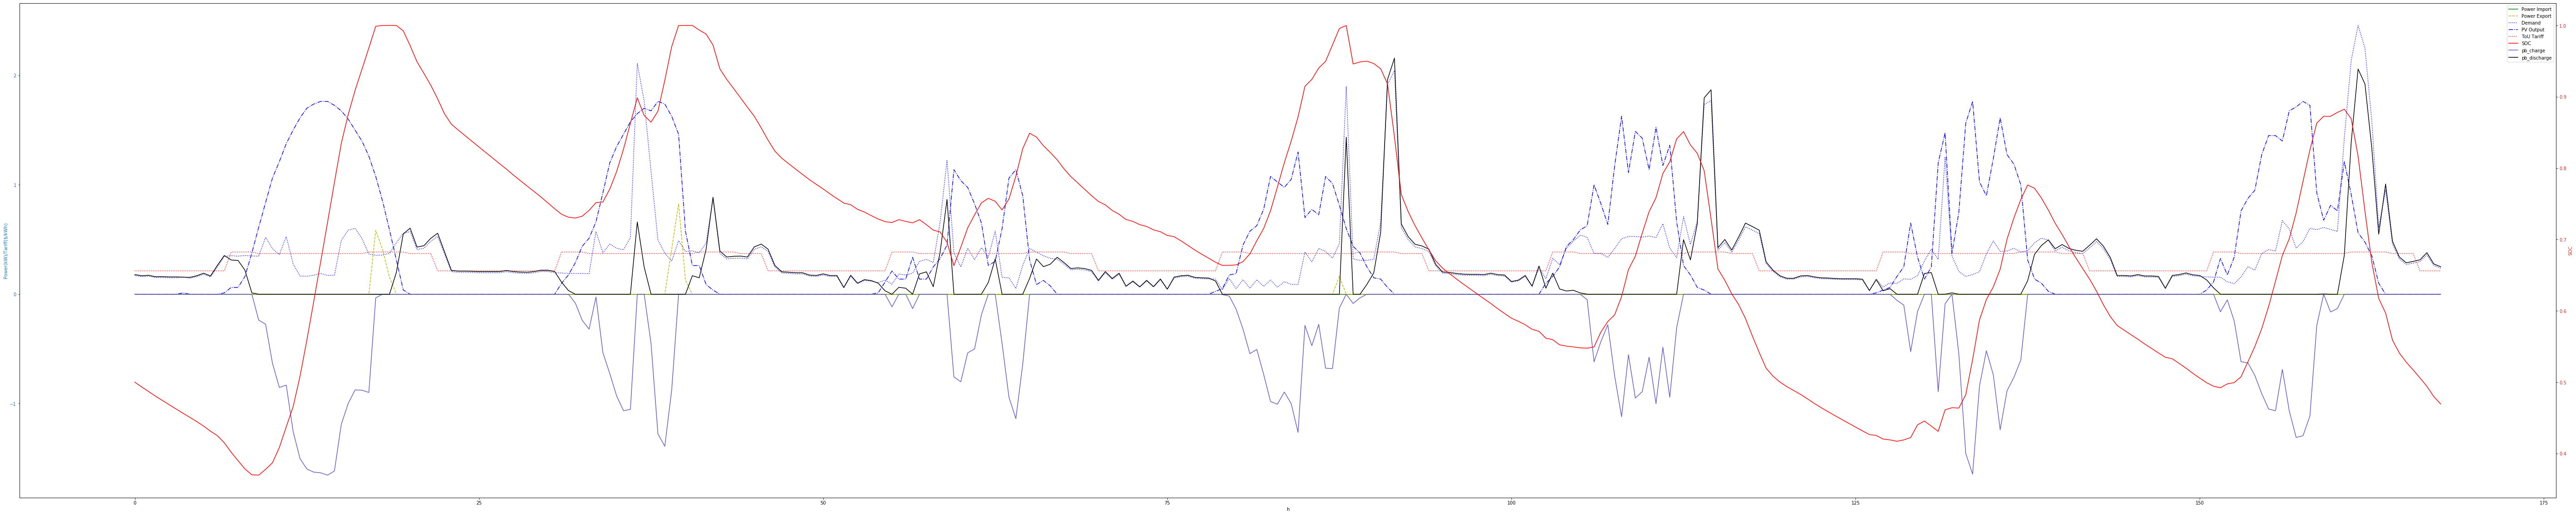

In [12]:
x = [0.5*i for i in range(48*7)]
y = [0.5*i for i in range(49)]

fig, ax1 = plt.subplots(figsize=(100,20))
color = 'tab:blue'
ax1.set_xlabel('h')
ax1.set_ylabel('Power(kW)/Tariff($/kWh)', color=color)
l1,=ax1.plot(x, np.array(pg_import), color='g',label='Power Import')
l2,=ax1.plot(x, np.array(pg_export), '--',color='y',label='Power Export')
l3,=ax1.plot(x, np.array(load),':',color='b',label='Demand')
l4,=ax1.plot(x, np.array(GGG),'-.',color='b',label='PV Output')
l5,=ax1.plot(x, T_tou1,':',color='r',label='ToU Tariff')
l7,=ax1.plot(x, -np.array(pb_c),color='slateblue',label='pb_charge')
l8,=ax1.plot(x, pb_d,color='k',label='pb_discharge')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('SOC', color=color)  # we already handled the x-label with ax1
l6,=ax2.plot(x, np.array(e_b)[:336]/14, 'r',label='SOC')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(handles=[l1,l2,l3,l4,l5,l6,l7,l8],loc=1)
#fig.tight_layout()
plt.show()

In [7]:
cost,dh,T_fit=0,0.5,0.09
for i in range(len(pg_import)):
    cost+=pg_import[i]*T_tou1[i]*dh-pg_export[i]*T_fit*dh
cost

2375.569538507714

In [12]:
def SCM(load,GG):
    pb_bar,bat_max,bat_min,eff_i,eff_c,dh,pg_bar=2.5,14,0,0.9,0.95,0.5,np.max(Total_Load_array)
    pg_import,pg_export,pb_c,pb_d,pb_res,soc,e_b,eb_res,p_res=[],[],[],[],[],[],[0.5*bat_max],[],[]
    for d in np.arange(14,360,1):
        for i in range(48):
            p_res[d].append(GG[d][i]-load[d][i])
            #print(p_res[d][-1])
            if(p_res[d][-1]>0.0):
                eb_res[d].append(bat_max-e_b[d][i])
                if(eb_res[d][-1]>0.0):
                    pb_c[d].append(min(pb_bar,min(abs(p_res[d][-1]),eb_res[d][-1]/(eff_c*dh))))
                    pg_export[d].append(abs(p_res[d][-1])-pb_c[d][-1])
                else:
                    pg_export[d][-1]=abs(p_res[d][-1])
            elif(p_res[d][-1]<0.0):
                eb_res[d].append(e_b[d][i]-bat_min)
                if(eb_res[d][-1]<0.1):
                    pg_import[d].append(abs(p_res[d][i]))
                else:
                    pb_d[d].append(min(pb_bar,min(abs(p_res[d][i]),(eb_res[d][i]*eff_c)/dh)))
                    pg_export[d].append(abs(p_res[d][i])-pb_d[d][i])
            else:
                pg_import[d].append(0.0)
                pg_export[d].append(0.0)
                pb_c[d].append(0.0)
                pb_d[d].append(0.0)
            e_b[d].append(e_b[d][i]+dh*(eff_c*pb_c[d][-1]-pb_d[d][-1]/eff_c))
    return pg_import,pg_export,pb_c,pb_d,e_b

In [10]:
load=[]
GGG=[]
T_tou1=[]
for i in np.arange(184,191,1):
    load.extend(Total_Load_array[i])
    GGG.extend(GG_array[i])
    T_tou1.extend(T_tou)

NameError: name 'T_tou' is not defined

In [ ]:
def SCM(load,GG):
    pb_bar,bat_max,bat_min,eff_i,eff_c,dh,pg_bar=2.5,14,0,0.9,0.95,0.5,np.max(load)
    pg_import,pg_export,pb_c,pb_d,pb_res,soc,e_b,eb_res,p_res=[],[],[],[],[],[],[0.5*bat_max],[],[]
    for d in np.arange(184,191,1):
        for i in range(48):
            p_res.append(GG[d][i]*eff_i-load[d][i])#KWH
            #print(p_res[-1])
            #print(i)
            if(p_res[-1]>0.0):#发电量能满足需求的情况
                eb_res.append(bat_max-e_b[-1])#千瓦时
                #print(eb_res[-1])
                if(eb_res[-1]>0.0):#电池还能充电
                    #pb_c设置为pb_bar、p_res、将电池充满需要的电量中的最小值
                    pb_c.append(min(pb_bar,min(abs(p_res[-1])*eff_i,(eb_res[-1])/(dh*eff_c))))#此处改动原文eb_res[-1]/(dh*eff_c)
                    pg_export.append(abs(p_res[-1])-pb_c[-1]/eff_i)#发电量满足充电后，卖电与eff_i有关
                    pb_d.append(0)#不放电
                    pg_import.append(0)#不用买电
                else:#电池满了，不能充电的情况
                    pg_export.append(abs(p_res[-1]))#直接卖电
                    pg_import.append(0)#不买电
                    pb_d.append(0)#不充电
                    pb_c.append(0)#不放电
            elif(p_res[-1]<0.0):#发电量不能满足需求的情况
                eb_res.append(e_b[-1]-bat_min)#电池可以放的电量
                #print(eb_res[-1])
                if(eb_res[-1]<0.01):#电池没电的情况
                    pg_import.append(abs(p_res[-1]))#买电，满足需求
                    pg_export.append(0)
                    pb_d.append(0)
                    pb_c.append(0)
                else:#电池有电的情况
                    pb_d.append(min(pb_bar,min(abs(p_res[-1])/eff_i,(eb_res[-1]*eff_c)/(dh))))#放到电池外面的电
                    pb_c.append(0)
                    pg_import.append((abs(p_res[-1])-pb_d[-1]*eff_i))#应该是买电，论文中的算法有错误
                    pg_export.append(0)
            else:
                pg_import.append(0.0)
                pg_export.append(0.0)
                pb_c.append(0.0)
                pb_d.append(0.0)
            e_b.append(e_b[-1]+dh*(eff_c*pb_c[-1]-pb_d[-1]/eff_c))
    return pg_import,pg_export,pb_c,pb_d,e_b

In [ ]:
def SCM(load,GG,pg_import,pg_export,pb_c,pb_d,pb_bar,bat_max,bat_min,eff_i,eff_c,dh,pg_bar,pred):
            p_res=GG[d][i]*eff_i-load[d][i]
            if(p_res>0.0):#发电量能满足需求的情况
                eb_res=bat_max-pred[-1]
                if(eb_res>0.0):#电池还能充电
                    #pb_c设置为pb_bar、p_res、将电池充满需要的电量中的最小值
                    pb_c[d][i]=min(pb_bar,min(abs(p_res)*eff_i,(eb_res)/(dh*eff_c)))#此处改动原文eb_res[-1]/(dh*eff_c)
                    pg_export[d][i]=abs(p_res)-pb_c[d][i]/eff_i#发电量满足充电后，卖电与eff_i有关
                    pb_d[d][i]=(0)#不放电
                    pg_import[d][i]=(0)#不用买电
                else:#电池满了，不能充电的情况
                    pg_export[d][i]=(abs(p_res))#直接卖电
                    pg_import[d][i]=(0)#不买电
                    pb_d[d][i]=(0)#不充电
                    pb_c[d][i]=(0)#不放电
            elif(p_res<0.0):#发电量不能满足需求的情况
                eb_res=(pred[-1]-bat_min)#电池可以放的电量
                if(eb_res<0.01):#电池没电的情况
                    pg_import[d][i]=(abs(p_res))#买电，满足需求
                    pg_export[d][i]=(0)
                    pb_d[d][i]=(0)
                    pb_c[d][i]=(0)
                else:#电池有电的情况
                    pb_d[d][i]=(min(pb_bar,min(abs(p_res)/eff_i,(eb_res*eff_c)/(dh))))#放到电池外面的电
                    pb_c[d][i]=(0)
                    pg_import[d][i]=((abs(p_res)-pb_d[d][i]*eff_i))#应该是买电，论文中的算法有错误
                    pg_export[d][i]=(0)
            else:
                pg_import[d][i]=(0.0)
                pg_export[d][i]=(0.0)
                pb_c[d][i]=(0.0)
                pb_d[d][i]=(0.0)
            pred.append(pred[-1]+dh*(eff_c*pb_c[d][i]-pb_d[d][i]/eff_c))
    return pg_import,pg_export,pb_c,pb_d,pred